In [1]:
# Set your student number and name
student_number = ('400104867','400108547')
Name = ('Payam Taebi','Parham Rezaei')

In [2]:
import random
import numpy as np

In [3]:
POSLIST = [5,3,2]
class Queue:
    def __init__(self, mode, capacity):
        self.mode = mode
        self.capacity = capacity
        self.queues = [[], [], []]  # LOW MID HIGH PRIOTIRY
        self.position = (5,5)

    def select_from_queue(self):
        if self.mode == "WRR":
            res = None
            LQ = self.queues[0]  # 1
            MQ = self.queues[1]  # 2
            HQ = self.queues[2]  # 3
            all = LQ + MQ + HQ
            if len(all) == 0:
                return
            
            i = 0
            while True:
                pos = POSLIST[i]
                if self.position[0] == pos:
                    if len(self.queues[i])>0:
                        self.position = (self.position[0],self.position[1]-1)
                        if self.position[1] == 0:
                            self.position = (POSLIST[(i+1)%3],POSLIST[(i+1)%3])
                        res = self.queues[i][0]
                        self.queues[i].remove(res)
                        return res
                    else:
                        self.position = (POSLIST[(i+1)%3],POSLIST[(i+1)%3])
                i =  (i+1)%3

            """pr = np.random.choice([1, 2, 3], 1, p=[0.5, 0.3, 0.2])[0]
            if len(self.queues[pr - 1]) != 0:
                res = self.queues[pr - 1][0]
                self.queues[pr - 1].remove(res)
                return res
            res = random.choice(all)
            if res in LQ:
                LQ.remove(res)
            if res in MQ:
                MQ.remove(res)
            if res in HQ:
                HQ.remove(res)
            return res"""


        else:
            res = None
            QUEUE = self.queues[0]
            if len(QUEUE) == 0:
                return None

            if self.mode == "FIFO":
                res = QUEUE[0]

            if self.mode == "NPPS":
                for i in QUEUE:
                    if i.priority == 1:
                        res = i
                        break

                for i in QUEUE:
                    if i.priority == 2:
                        res = i
                        break

                for i in QUEUE:
                    if i.priority == 3:
                        res = i
                        break
            if res in QUEUE:
                QUEUE.remove(res)
            return res

    def add(self, packet):
        queue = None
        if self.mode == "WRR":
            #print(len(self.queues[0]),len(self.queues[1]),len(self.queues[2]))
            pr = packet.priority
            queue = self.queues[pr - 1]
        else:
            queue = self.queues[0]

        if len(queue) < self.capacity:
            queue.append(packet)
        else:
            packet.drop = True
            DROP_PACKETS.append(packet)

    def is_empty(self):
        LQ = self.queues[0]  # 1
        MQ = self.queues[1]  # 2
        HQ = self.queues[2]  # 3
        all = LQ + MQ + HQ
        if len(all) == 0:
            return True
        return False


In [4]:
class Packet:
    def __init__(self, generated_time):
        self.generated_time = generated_time
        self.priority = np.random.choice([1, 2, 3], 1, p=[0.5, 0.3, 0.2])[0]
        self.drop = False
        self.start_service_time = 0
        self.service_time = 0
        self.end_time = 0
        self.done = False
        self.doneByServer = None

    def show(self):
        if self.done:
            print("generated time = ", self.generated_time, "priority =", self.priority, "drop =", self.drop,
                  "start_service_time =", self.start_service_time, "service_time =", self.service_time, "end_time =",
                  self.end_time, "done =", self.done, "done by server number = ", self.doneByServer.number)
        else:
            print("generated time = ", self.generated_time, "priority =", self.priority, "drop =", self.drop, "done =",
                  self.done)

In [5]:
class Server:
    def __init__(self, number,rate):
        self.current_packet = None
        self.number = number
        self.finished_packets = []
        self.rate = rate

    def select_packet(self):
        self.current_packet = QUEUE.select_from_queue()
        if self.current_packet is not None:
            self.current_packet.start_service_time = Time
            self.current_packet.service_time = generate_exp_sample_for_serves(1 / self.rate)
            self.current_packet.doneByServer = self

    def check_packet_ready(self):
        if self.current_packet is not None:
            if (self.current_packet.service_time + self.current_packet.start_service_time) <= Time:
                self.current_packet.done = True
                self.current_packet.end_time = Time
                self.finished_packets.append(self.current_packet)
                FINISHED_PACKET.append(self.current_packet)
                self.current_packet = None


In [6]:
def generate_exp_sample_for_serves(landa):
    return np.random.exponential(landa, 1)[0]
    # = -LN(R)/landa


def generate_exp_sample(t, landa,END_TIME):
    res = []
    while sum(res) < t:
        res.append(np.random.exponential(landa, 1)[0])
    for i in range(1, len(res)):
        res[i] += res[i - 1]
    if res[-1] >= END_TIME:
        res = res[:-1]
    return res

In [7]:
def host(exp_times):
    while len(exp_times) != 0 and Time >= exp_times[0]:
        generated_packet = Packet(Time)
        ALL_PACKET.append(generated_packet)
        POPULATION.append(generated_packet)
        exp_times = exp_times[1:]
    return exp_times


def queueing():
    global POPULATION
    while len(POPULATION) > 0:
        QUEUE.add(POPULATION[0])
        POPULATION = POPULATION[1:]


def router():
    if QUEUE.is_empty():
        return
    for server in PROCESSORS:
        if server.current_packet is None:
            server.select_packet()


def server():
    for server in PROCESSORS:
        server.check_packet_ready()


def get_next_time(exp_times):
    MIN_TIME = np.inf
    for server in PROCESSORS:
        if server.current_packet is not None:
            MIN_TIME = min(MIN_TIME, server.current_packet.start_service_time + server.current_packet.service_time)
    if len(exp_times) != 0:
        MIN_TIME = min(MIN_TIME, exp_times[0])
    return MIN_TIME


def create_server(NUMBER_OF_SERVERS,Y):
    for i in range(NUMBER_OF_SERVERS):
        PROCESSORS.append(Server(i + 1,Y))
    return

def reset_globals():
    global Time, QUEUE,PROCESSORS,POPULATION,DROP_PACKETS,FINISHED_PACKET,ALL_PACKET
    Time = 0
    QUEUE = None
    PROCESSORS = []
    POPULATION = []
    DROP_PACKETS = []
    ALL_PACKET = []
    FINISHED_PACKET = []

In [8]:
def details(All):
    # number of drops
    drop_packets = []
    finished_packet = []
    not_drop_packets = []
    for i in All:
        if i.done:
            finished_packet.append(i)
        if not i.drop:
            not_drop_packets.append(i)
        if i.drop:
            drop_packets.append(i)

    print("Time is ",Time)
    print("-----------Dropped Packets----------\n")
    print(f"Number of All Generated packets: {len(All)}")
    print(f"Number of dropped packets: {len(drop_packets)}")
    print(f"Number of not dropped packets: {len(not_drop_packets)}")
    print(f"Number of finished packets: {len(finished_packet)}")

    print("\n-----------Average Time Spent in Lines------------\n")
    # average time spent in lines
    if QUEUE.mode != "WRR":
        times = []
        for packet in not_drop_packets:
            if packet.start_service_time >= packet.generated_time:  ##yani age rafte to server
                times.append(packet.start_service_time - packet.generated_time)
            else:
                times.append(Time - packet.generated_time)
        if len(times) == 0:
            print("No packet in Queue")
        else:
            print(f"\nAverage Time in the Queue {sum(times) / len(times)}")
    else:
        times = [[], [], []]

        for packet in not_drop_packets:
            if packet.start_service_time >= packet.generated_time:  ##yani age rafte to server
                times[packet.priority - 1].append(packet.start_service_time - packet.generated_time)
            else:
                times[packet.priority - 1].append(Time - packet.generated_time)

        for i in range(3):
            if len(times[i]) == 0:
                print(f"No packet in Queue {i + 1}")
            else:
                print(f"Average Time in Queue {i + 1}: {sum(times[i]) / len(times[i])}")

    print("\n-----------Average Time Spent in All Lines-------------\n")
    # average time spent in all lines
    times = []
    for packet in not_drop_packets:
        if packet.start_service_time >= packet.generated_time:  ##yani age rafte to server
            times.append(packet.start_service_time - packet.generated_time)
        else:
            times.append(Time - packet.generated_time)
    if len(times) == 0:
        print("No packet in Queue")
    else:
        print(f"\nAverage Time in the Queue {sum(times) / len(times)}")

    print("\n----------------Processor utilization--------------\n")
    processor_busy = {}
    for i in PROCESSORS:
        processor_busy[i.number] = 0
    for packet in not_drop_packets:
        if packet.doneByServer is not None:
            if packet.done:
                processor_busy[packet.doneByServer.number] += packet.service_time
            else:
                processor_busy[packet.doneByServer.number] += Time - packet.start_service_time

    for i in PROCESSORS:
        print(f"{i.number}: busy time: {processor_busy[i.number]}, utilization = {processor_busy[i.number] / Time}")

    print("\n---------------Average Length of Each Queue------------\n")

    times = [0, 0, 0]
    for packet in not_drop_packets:
        if QUEUE.mode != "WRR":
            if packet.start_service_time >= packet.generated_time:  ##yani age rafte to server
                times[0] += packet.start_service_time - packet.generated_time
            else:
                times[0] += Time - packet.generated_time


        else:
            if packet.start_service_time >= packet.generated_time:  ##yani age rafte to server
                times[packet.priority - 1] += packet.start_service_time - packet.generated_time
            else:
                times[packet.priority - 1] += Time - packet.generated_time

    if QUEUE.mode != "WRR":
        print(f"Average Length of Queue is : {times[0] / Time}")
    else:
        for i in range(3):
            print(f"Average Length of Queue {i} is : {times[i] / Time}")

    print("\n-------------CDF of Packets with High Priority-----------\n")
    # cdf of packets with high in scheduling modes
    # TODO : age lazeme onaye ke drop shodan 0 ezafe she
    high_time_spent = []
    for packet in not_drop_packets:
        if packet.priority == 3:
            if packet.start_service_time >= packet.generated_time:  ##yani age rafte to server
                high_time_spent.append(packet.start_service_time - packet.generated_time)
            else:
                high_time_spent.append(Time - packet.generated_time)

    import matplotlib.pyplot as plt
    times_sorted = np.sort(high_time_spent)
    p = 1. * np.arange(len(high_time_spent)) / (len(high_time_spent) - 1)
    plt.plot(times_sorted, p)
    plt.title("CDF of High Priority Packets Queue Wait Time ")
    plt.xlabel("x")
    plt.ylabel("F(x)")
    plt.show()


In [9]:
QUEUE = None
PROCESSORS = []
Time = 0
POPULATION = []
DROP_PACKETS = []
ALL_PACKET = []
FINISHED_PACKET = []

def RUN(SERVICE_POLICY, QUEUE_CAPACITY ,NUMBER_OF_SERVERS,END_TIME,X,Y):
    """harh bar ke RUN konin khoroji be shekl
        QUEUE = None
        PROCESSORS = []
        Time = 0
        POPULATION = []
        DROP_PACKETS = []
        FINISHED_PACKET = []
        amade hast va ta Run badi anjam nashe data save mimoone
    """
    global Time, QUEUE
    reset_globals()
        
    QUEUE = Queue(SERVICE_POLICY, QUEUE_CAPACITY)
    create_server(NUMBER_OF_SERVERS,Y)
    exp_times = generate_exp_sample(END_TIME, 1 / X,END_TIME)

    while True:
        exp_times = host(exp_times)  # age chizi gharare generate beshe beshe
        server()  # age az ghabl hizi amadas raha kone
        router()  # hala ke server ghatan dastesh bande biyaym bebinim saf ro mishe khali kard ya na
        server()  # baz age momkene server khali she [baraye service rime = 0]
        queueing()  # hala adam jadid biyad too saf
        router()  # assign beshe
        server()  # karesh anjam beshe
        tmp = Time
        Time = get_next_time(exp_times)
        if Time >= END_TIME:
            Time = tmp
            return



In [10]:
RUN(SERVICE_POLICY="FIFO", QUEUE_CAPACITY=3 ,NUMBER_OF_SERVERS=1,END_TIME=500,X=20,Y=5)

Time is  499.99165827198533
-----------Dropped Packets----------

Number of All Generated packets: 10099
Number of dropped packets: 7575
Number of not dropped packets: 2524
Number of finished packets: 2524

-----------Average Time Spent in Lines------------


Average Time in the Queue 0.5295057773521802

-----------Average Time Spent in All Lines-------------


Average Time in the Queue 0.5295057773521802

----------------Processor utilization--------------

1: busy time: 498.6749094331299, utilization = 0.9973664583857135

---------------Average Length of Each Queue------------

Average Length of Queue is : 2.672989758780913

-------------CDF of Packets with High Priority-----------



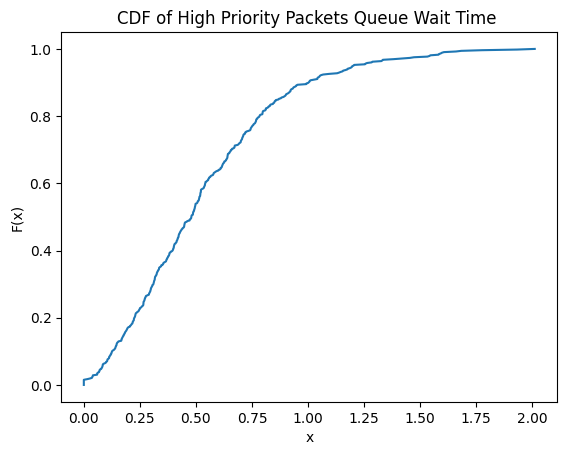

In [11]:
details(ALL_PACKET)

In [12]:
# EVALUATION

Time is  499.9901893160304
-----------Dropped Packets----------

Number of All Generated packets: 10006
Number of dropped packets: 2816
Number of not dropped packets: 7190
Number of finished packets: 7185

-----------Average Time Spent in Lines------------


Average Time in the Queue 0.2092080201321586

-----------Average Time Spent in All Lines-------------


Average Time in the Queue 0.2092080201321586

----------------Processor utilization--------------

1: busy time: 485.463822679184, utilization = 0.9709466966607525
2: busy time: 479.2573732430547, utilization = 0.9585335542256589
3: busy time: 473.04235907270385, utilization = 0.946103281986012

---------------Average Length of Each Queue------------

Average Length of Queue is : 3.0084703598043046

-------------CDF of Packets with High Priority-----------



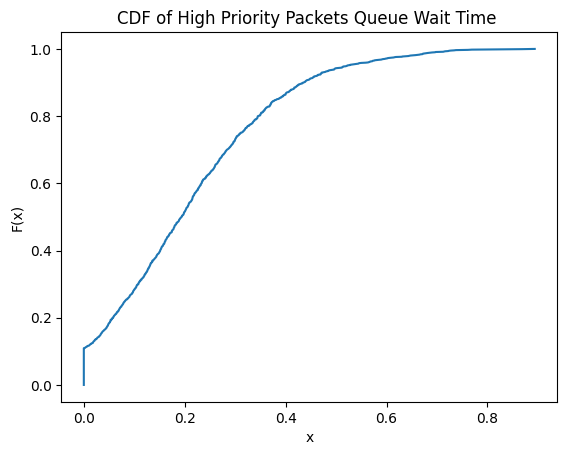

In [13]:
RUN(SERVICE_POLICY="FIFO", QUEUE_CAPACITY=5 ,NUMBER_OF_SERVERS=3,END_TIME=500,X=20,Y=5)
details(ALL_PACKET)

Time is  499.8897790017143
-----------Dropped Packets----------

Number of All Generated packets: 10046
Number of dropped packets: 2548
Number of not dropped packets: 7498
Number of finished packets: 7486

-----------Average Time Spent in Lines------------

Average Time in Queue 1: 0.4068319565902139
Average Time in Queue 2: 0.6734589235104985
Average Time in Queue 3: 0.9669494604237165

-----------Average Time Spent in All Lines-------------


Average Time in the Queue 0.6020890472991698

----------------Processor utilization--------------

1: busy time: 496.7919018695154, utilization = 0.9938028796300148
2: busy time: 495.0039481963672, utilization = 0.9902261838297551
3: busy time: 493.5648589615982, utilization = 0.9873473707489138

---------------Average Length of Each Queue------------

Average Length of Queue 0 is : 3.01122027817782
Average Length of Queue 1 is : 3.0447055152302025
Average Length of Queue 2 is : 2.974992353517546

-------------CDF of Packets with High Priority--

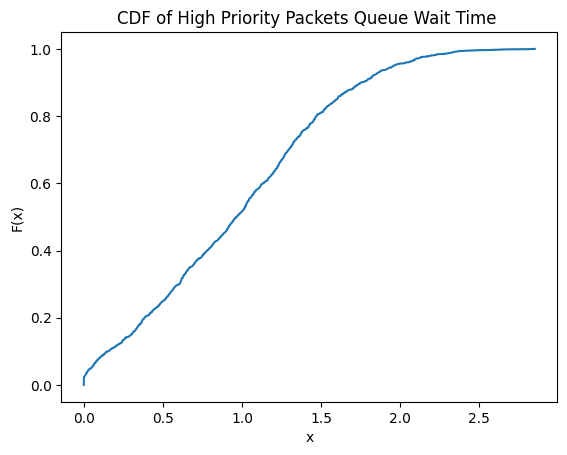

In [14]:
RUN(SERVICE_POLICY="WRR", QUEUE_CAPACITY=5 ,NUMBER_OF_SERVERS=3,END_TIME=500,X=20,Y=5)
details(ALL_PACKET)

Time is  499.9839981837662
-----------Dropped Packets----------

Number of All Generated packets: 9930
Number of dropped packets: 2826
Number of not dropped packets: 7104
Number of finished packets: 7096

-----------Average Time Spent in Lines------------


Average Time in the Queue 0.21656661980814038

-----------Average Time Spent in All Lines-------------


Average Time in the Queue 0.21656661980814038

----------------Processor utilization--------------

1: busy time: 486.978866608544, utilization = 0.9739889044000121
2: busy time: 482.43794934903036, utilization = 0.9649067792199885
3: busy time: 478.4187630847649, utilization = 0.9568681494261041

---------------Average Length of Each Queue------------

Average Length of Queue is : 3.077077011875821

-------------CDF of Packets with High Priority-----------



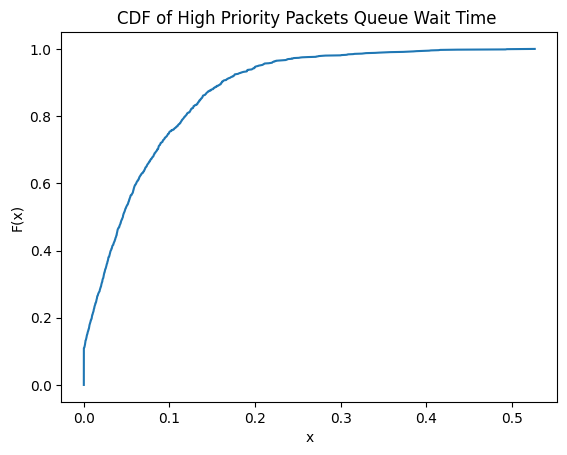

In [15]:
RUN(SERVICE_POLICY="NPPS", QUEUE_CAPACITY=5 ,NUMBER_OF_SERVERS=3,END_TIME=500,X=20,Y=5)
details(ALL_PACKET)

In [16]:
def compare(QUEUE_CAPACITY ,NUMBER_OF_SERVERS,END_TIME,X,Y):
    print(" all packet||drop packet||finished packet")
    RUN("FIFO",QUEUE_CAPACITY ,NUMBER_OF_SERVERS,END_TIME,X,Y)
    print("FIFO: ",len(ALL_PACKET),len(DROP_PACKETS),len(FINISHED_PACKET))
    RUN("WRR",QUEUE_CAPACITY ,NUMBER_OF_SERVERS,END_TIME,X,Y)
    print("WRR: ",len(ALL_PACKET),len(DROP_PACKETS),len(FINISHED_PACKET))
    RUN("NPPS",QUEUE_CAPACITY ,NUMBER_OF_SERVERS,END_TIME,X,Y)
    print("NPPS: ",len(ALL_PACKET),len(DROP_PACKETS),len(FINISHED_PACKET))
    print("____")
    

In [17]:
compare(QUEUE_CAPACITY=10 ,NUMBER_OF_SERVERS=3,END_TIME=500,X=10,Y=3)
compare(QUEUE_CAPACITY=1 ,NUMBER_OF_SERVERS=3,END_TIME=500,X=10,Y=3)
compare(QUEUE_CAPACITY=1 ,NUMBER_OF_SERVERS=1,END_TIME=500,X=10,Y=3)
compare(QUEUE_CAPACITY=10 ,NUMBER_OF_SERVERS=50,END_TIME=500,X=10,Y=3)
compare(QUEUE_CAPACITY=10 ,NUMBER_OF_SERVERS=3,END_TIME=500,X=5,Y=10)
compare(QUEUE_CAPACITY=1 ,NUMBER_OF_SERVERS=1,END_TIME=500,X=5,Y=10)
compare(QUEUE_CAPACITY=10 ,NUMBER_OF_SERVERS=10,END_TIME=500,X=5,Y=10)

 all packet||drop packet||finished packet
FIFO:  5144 841 4290
WRR:  5039 621 4394
NPPS:  5082 792 4277
____
 all packet||drop packet||finished packet
FIFO:  5091 1481 3607
WRR:  5037 1276 3758
NPPS:  5081 1554 3525
____
 all packet||drop packet||finished packet
FIFO:  5022 3632 1388
WRR:  5055 3558 1493
NPPS:  4972 3555 1415
____
 all packet||drop packet||finished packet
FIFO:  4975 0 4973
WRR:  4900 0 4898
NPPS:  5003 0 4999
____
 all packet||drop packet||finished packet
FIFO:  2508 0 2508
WRR:  2481 0 2481
NPPS:  2433 0 2432
____
 all packet||drop packet||finished packet
FIFO:  2489 348 2141
WRR:  2466 209 2255
NPPS:  2580 371 2209
____
 all packet||drop packet||finished packet
FIFO:  2535 0 2534
WRR:  2518 0 2517
NPPS:  2476 0 2476
____


In [18]:
"""
According to the tests and comparisons, probably WRR is better than the other two queues, which is probably because the probability of each queue is equal to the possibility of producing a Packet for that queue, which means we have FIFO. Whose queue length has tripled
According to the above comparisons, it can be seen that the number of DROP PACKET is less in this case and the number of FINISHED PACKET is more than two other modes
"""

'\nAccording to the tests and comparisons, probably WRR is better than the other two queues, which is probably because the probability of each queue is equal to the possibility of producing a Packet for that queue, which means we have FIFO. Whose queue length has tripled\nAccording to the above comparisons, it can be seen that the number of DROP PACKET is less in this case and the number of FINISHED PACKET is more than two other modes\n'

In [19]:
"""""""""
There are several ways to increase the utilization of the server in a multi-server and queue system with weighted round-robin (WRR), number of packets per second (NPPS), and first-in first-out (FIFO) scheduling policies:

1. Increase the arrival rate of customers: This can be done by increasing the generation ratio of customers to the system. However, this may not always be feasible or desirable, as it may lead to longer waiting times for customers and decreased customer satisfaction.

2. Decrease the service time of each server: This can be done by increasing the processing speed of each server or reducing the amount of work required for each customer. However, this may not always be possible, as there may be physical or practical limitations to how fast each server can process customer requests.

3. Increase the number of servers: Adding more servers to the system can increase the capacity of the system and allow for more customers to be served simultaneously. This can improve the utilization of the servers and reduce waiting times for customers.

4. Adjust the scheduling policies: The scheduling policies used in the system can also affect server utilization. For example, using a more aggressive WRR policy that allocates more packets to servers with higher weights can improve utilization. Similarly, using a more aggressive NPPS policy that allows for more packets to be processed per second can also increase utilization. However, these policies may also lead to longer waiting times for customers and decreased customer satisfaction.

5. Optimize system parameters: There may be other system parameters that can be optimized to improve server utilization, such as buffer sizes, packet sizes, or queue thresholds. These optimizations may require careful analysis of the system and its performance characteristics, and may require trade-offs between server utilization and other performance metrics such as waiting times or packet loss rates.
"""""""""

'\nThere are several ways to increase the utilization of the server in a multi-server and queue system with weighted round-robin (WRR), number of packets per second (NPPS), and first-in first-out (FIFO) scheduling policies:\n\n1. Increase the arrival rate of customers: This can be done by increasing the generation ratio of customers to the system. However, this may not always be feasible or desirable, as it may lead to longer waiting times for customers and decreased customer satisfaction.\n\n2. Decrease the service time of each server: This can be done by increasing the processing speed of each server or reducing the amount of work required for each customer. However, this may not always be possible, as there may be physical or practical limitations to how fast each server can process customer requests.\n\n3. Increase the number of servers: Adding more servers to the system can increase the capacity of the system and allow for more customers to be served simultaneously. This can impro